# Zero-Delay Feedback Ladder Filter

## Import Libraries

In [2]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import math

## Generate Waveform

In [3]:
# user variables
wave_freq = 100.0 #Hz
cycles = 5
samplerate = 48000

# conversions / calculations
duration = cycles / wave_freq #sec
duration_ms = duration * 1000.0 #msec
lengthInSamps = math.ceil(duration * samplerate)

# create time axis
time = np.linspace(0, duration, lengthInSamps)

# choose a waveform
wave = signal.sawtooth(2.0*np.pi*wave_freq*time)
#wave = signal.square(2.0*np.pi*wave_freq*time, duty=(2.0*np.pi*time + 1)/2)

## Calculate Filter

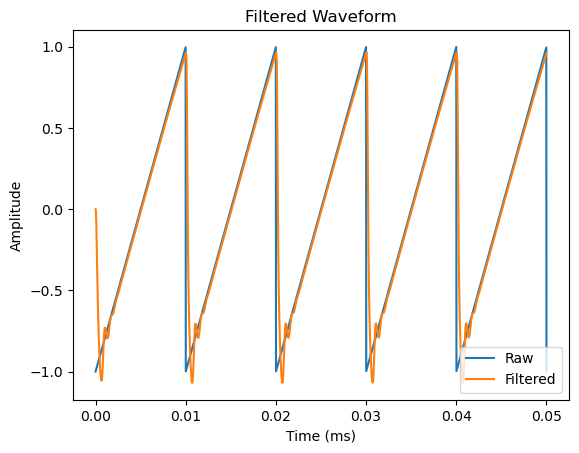

Maximum iterations: 4
CPU times: user 1.76 s, sys: 834 ms, total: 2.59 s
Wall time: 941 ms


In [4]:
%%time

# filter parameters
input_gain = 2.6
cutoff = 3000.0
r = 1.6 # resonance (0.0 to 4.0)

g = cutoff * np.pi / samplerate
boosted_wave = wave * input_gain

# initial values
y = np.array([0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0

# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):

        # F(y) using current y values
        y1 = g*(np.tanh(x-r*y[3])-np.tanh(y[0])) + s1 - y[0]
        y2 = g*(np.tanh(y[0])-np.tanh(y[1])) + s2 - y[1]
        y3 = g*(np.tanh(y[1])-np.tanh(y[2])) + s3 - y[2]
        y4 = g*(np.tanh(y[2])-np.tanh(y[3])) + s4 - y[3]
        F = np.array([y1, y2, y3, y4]).T

        # Jacobian Matrix
        J = np.array([
            [(-g*(1.0-(np.tanh(y[0])**2))-1.0), 0.0, 0.0, (g*-r*(1.0-(np.tanh(x-r*y[3])**2)))],
            [(g*(1.0-(np.tanh(y[0])**2))), (-g*(1.0-(np.tanh(y[1])**2))-1.0), 0.0, 0.0],
            [0.0, (g*(1.0-(np.tanh(y[1])**2))), (-g*(1.0-(np.tanh(y[2])**2))-1.0), 0.0],
            [0.0, 0.0, (g*(1.0-(np.tanh(y[2])**2))), (-g*(1.0-(np.tanh(y[3])**2))-1.0)]])

        # calculate next NR step
        y_est = y
        y = y - np.matmul(inv(J), F)
        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()

# print max iterations
print("Maximum iterations: " + str(maxIter))

## Optimizations

1. Precalculate Tanh()
2. Replace matrix inversion with solver

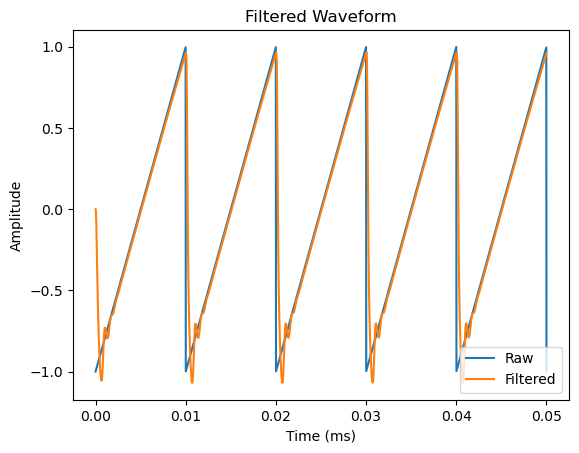

Maximum iterations: 4
CPU times: user 1.01 s, sys: 93.7 ms, total: 1.11 s
Wall time: 1.07 s


In [80]:
%%time

# filter parameters
input_gain = 2.6
cutoff = 3000.0
r = 1.6 # resonance (0.0 to 4.0)

g = cutoff * np.pi / samplerate
boosted_wave = wave * input_gain

# initial values
y = np.array([0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0

# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):
        # pre-compute tanh functions
        tanh_x_ry4 = np.tanh(x-r*y[3])
        tanh_y1 = np.tanh(y[0])
        tanh_y2 = np.tanh(y[1])
        tanh_y3 = np.tanh(y[2])
        tanh_y4 = np.tanh(y[3])
        
        # F(y) using current y values
        y1 = g*(tanh_x_ry4-tanh_y1) + s1 - y[0]
        y2 = g*(tanh_y1-tanh_y2) + s2 - y[1]
        y3 = g*(tanh_y2-tanh_y3) + s3 - y[2]
        y4 = g*(tanh_y3-tanh_y4) + s4 - y[3]
        F = np.array([y1, y2, y3, y4]).T

        # pre-compute re-used algebra (helper "functions")
        help_x_ry4 = 1.0 - (tanh_x_ry4 * tanh_x_ry4)
        help_y1 = 1.0 - (tanh_y1 * tanh_y1)
        help_y2 = 1.0 - (tanh_y2 * tanh_y2)
        help_y3 = 1.0 - (tanh_y3 * tanh_y3)
        help_y4 = 1.0 - (tanh_y4 * tanh_y4)
        
        # Jacobian Matrix        
        J = np.array([
            [(-g*help_y1 - 1.0), 0.0, 0.0, (g*-r*help_x_ry4)],
            [(g*help_y1), (-g*help_y2-1.0), 0.0, 0.0],
            [0.0, (g*help_y2), (-g*help_y3 - 1.0), 0.0],
            [0.0, 0.0, (g*help_y3), (-g*help_y4-1.0)]])

        # calculate next NR step
        y_est = y
        #y = y - np.matmul(inv(J), F)
        delta_y = np.linalg.solve(J, -1*F) # linear solver replaces the matrix inversion equation above
        y = delta_y + y            
        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()
#plt.savefig('square1.png')

# print max iterations
print("Maximum iterations: " + str(maxIter))

## With Feedback
(not optimized)

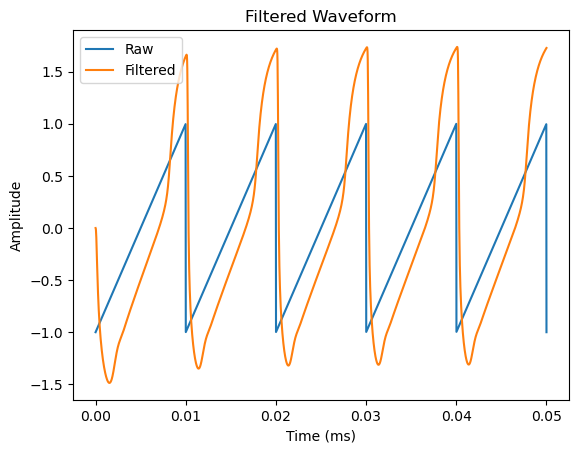

Maximum iterations: 4
CPU times: user 2.71 s, sys: 1.02 s, total: 3.74 s
Wall time: 1.47 s


In [112]:
%%time

# filter parameters
input_gain = 1.5
cutoff = 3000.0
r = 0.5 # resonance (0.0 to 4.0)
fbk = 4.0
b = 0.5 # negative bias on headphone / ext amplifier (feedback)

g = cutoff * np.pi / samplerate
boosted_wave = wave * input_gain

# initial values
y = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# highpass filter
Fc_hp = 12.0
g_hp = Fc_hp * np.pi / samplerate

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0
s5 = 0.0

# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):

        # F(y) using current y values
        y1 = g*(np.tanh(x-r*y[3]+y[4])-np.tanh(y[0])) + s1 - y[0]
        y2 = g*(np.tanh(y[0])-np.tanh(y[1])) + s2 - y[1]
        y3 = g*(np.tanh(y[1])-np.tanh(y[2])) + s3 - y[2]
        y4 = g*(np.tanh(y[2])-np.tanh(y[3])) + s4 - y[3]
        y5 = (np.tanh(fbk*(y[3]-b)) + s5) / (1.0 + g_hp) - y[4]
        F = np.array([y1, y2, y3, y4, y5]).T

        # Jacobian Matrix
        J = np.array([
            [(-g*(1.0-(np.tanh(y[0])**2))-1.0), 0.0, 0.0, (g*-r*(1.0-(np.tanh(x-r*y[3]+y[4])**2))), (g*(1.0-(np.tanh(x-r*y[3]+y[4])**2)))],
            [(g*(1.0-(np.tanh(y[0])**2))), (-g*(1.0-(np.tanh(y[1])**2))-1.0), 0.0, 0.0, 0.0],
            [0.0, (g*(1.0-(np.tanh(y[1])**2))), (-g*(1.0-(np.tanh(y[2])**2))-1.0), 0.0, 0.0],
            [0.0, 0.0, (g*(1.0-(np.tanh(y[2])**2))), (-g*(1.0-(np.tanh(y[3])**2))-1.0), 0.0],
            [0.0, 0.0, 0.0, (fbk*(1.0-np.tanh(fbk*(y[3]-b))**2)/(1.0 + g_hp)), -1.0]])

        # calculate next NR step
        y_est = y
        y = y - np.matmul(inv(J), F)
        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    s5 = 2.0 * (y[4] - np.tanh(fbk*(y[3]-b))) - s5

    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()

# print max iterations
print("Maximum iterations: " + str(maxIter))

## With Feedback AND Optimized

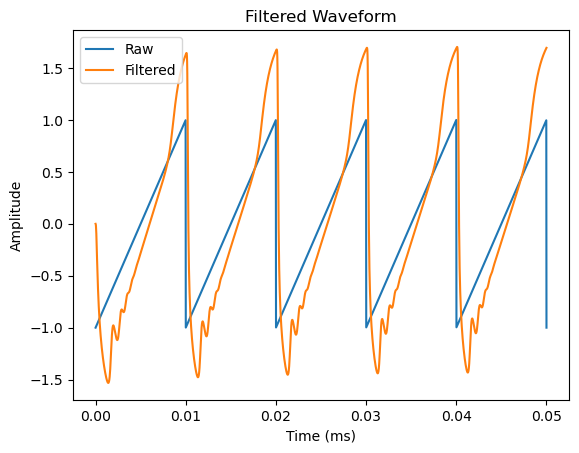

Maximum iterations: 4
CPU times: user 1.15 s, sys: 80.2 ms, total: 1.23 s
Wall time: 1.28 s


In [115]:
%%time

# filter parameters
input_gain = 4.0
cutoff = 3000.0
r = 2.0 # resonance (0.0 to 4.0)
fbk = 5.0
b = 0.8 # negative bias on headphone / ext amplifier (feedback)

g = cutoff * np.pi / samplerate
boosted_wave = wave * input_gain

# highpass filter
Fc_hp = 8.0
g_hp = Fc_hp * np.pi / samplerate

# initial values
y = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0
s5 = 0.0

# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):
        # pre-compute tanh functions
        tanh_x = np.tanh(x-r*y[3]+y[4])
        tanh_y1 = np.tanh(y[0])
        tanh_y2 = np.tanh(y[1])
        tanh_y3 = np.tanh(y[2])
        tanh_y4 = np.tanh(y[3])
        tanh_y5 = np.tanh(fbk*(y[3]-b))
        
        # F(y) using current y values
        y1 = g*(tanh_x-tanh_y1) + s1 - y[0]
        y2 = g*(tanh_y1-tanh_y2) + s2 - y[1]
        y3 = g*(tanh_y2-tanh_y3) + s3 - y[2]
        y4 = g*(tanh_y3-tanh_y4) + s4 - y[3]
        y5 = (tanh_y5 + s5) / (1.0 + g_hp) - y[4]
        F = np.array([y1, y2, y3, y4, y5]).T

        # pre-compute re-used algebra (helper "functions")
        help_x = 1.0 - (tanh_x * tanh_x)
        help_y1 = 1.0 - (tanh_y1 * tanh_y1)
        help_y2 = 1.0 - (tanh_y2 * tanh_y2)
        help_y3 = 1.0 - (tanh_y3 * tanh_y3)
        help_y4 = 1.0 - (tanh_y4 * tanh_y4)
        help_y5 = 1.0 - (tanh_y5 * tanh_y5)
        
        # Jacobian Matrix        
        J = np.array([
            [(-g*help_y1 - 1.0), 0.0, 0.0, (g*-r*help_x), (g*help_x)],
            [(g*help_y1), (-g*help_y2-1.0), 0.0, 0.0, 0.0],
            [0.0, (g*help_y2), (-g*help_y3 - 1.0), 0.0, 0.0],
            [0.0, 0.0, (g*help_y3), (-g*help_y4-1.0), 0.0],
            [0.0, 0.0, 0.0, (fbk/(1.0 + g_hp))*help_y5, -1.0]])

        # calculate next NR step
        y_est = y
        #y = y - np.matmul(inv(J), F)
        delta_y = np.linalg.solve(J, -1*F) # linear solver replaces the matrix inversion equation above
        y = delta_y + y            
        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    s5 = 2.0 * (y[4] - tanh_y5) - s5
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()
#plt.savefig('square1.png')

# print max iterations
print("Maximum iterations: " + str(maxIter))

## Alternative Matrix Solver

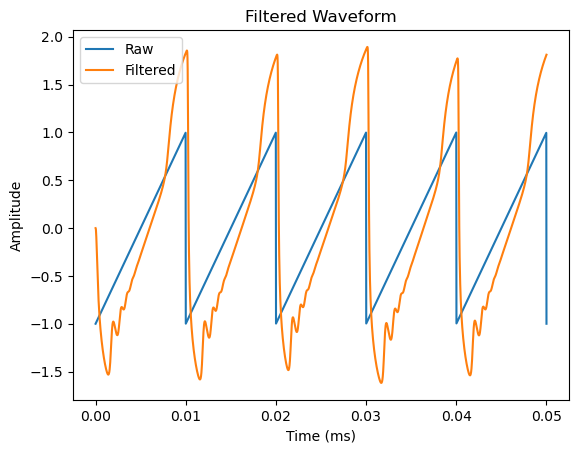

Maximum iterations: 1
CPU times: user 818 ms, sys: 71.3 ms, total: 889 ms
Wall time: 925 ms


In [116]:
%%time

# filter parameters
input_gain = 4.0
cutoff = 3000.0
r = 2.0 # resonance (0.0 to 4.0)
fbk = 5.0
b = 0.8 # negative bias on headphone / ext amplifier (feedback)

g = cutoff * np.pi / samplerate
boosted_wave = wave * input_gain

# highpass filter
Fc_hp = 8.0
g_hp = Fc_hp * np.pi / samplerate
g_den = 1.0 + g_hp

# initial values
y = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0
s5 = 0.0

# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):
        # pre-compute tanh functions
        tanh_x = np.tanh(x-r*y[3]+y[4])
        tanh_y1 = np.tanh(y[0])
        tanh_y2 = np.tanh(y[1])
        tanh_y3 = np.tanh(y[2])
        tanh_y4 = np.tanh(y[3])
        tanh_y5 = np.tanh(fbk*(y[3]-b))
        
        # F(y) using current y values
        y1 = g*(tanh_x-tanh_y1) + s1 - y[0]
        y2 = g*(tanh_y1-tanh_y2) + s2 - y[1]
        y3 = g*(tanh_y2-tanh_y3) + s3 - y[2]
        y4 = g*(tanh_y3-tanh_y4) + s4 - y[3]
        y5 = (tanh_y5 + s5) / g_den - y[4]
        F = np.array([y1, y2, y3, y4, y5]).T

        # pre-compute re-used algebra (helper "functions")
        help_x = 1.0 - (tanh_x * tanh_x)
        help_y1 = 1.0 - (tanh_y1 * tanh_y1)
        help_y2 = 1.0 - (tanh_y2 * tanh_y2)
        help_y3 = 1.0 - (tanh_y3 * tanh_y3)
        help_y4 = 1.0 - (tanh_y4 * tanh_y4)
        help_y5 = 1.0 - (tanh_y5 * tanh_y5)
        
        # Jacobian Matrix Elements
        j00 = -g*help_y1 - 1.0
        j03 = g*-r*help_x
        j04 = g*help_x
        j10 = g*help_y1
        j11 = -g*help_y2 - 1.0
        j21 = g*help_y2
        j22 = -g*help_y3 - 1.0
        j32 = g*help_y3
        j33 = -g*help_y4 - 1.0
        j43 = fbk*help_y5/g_den

        
        """
        # Original Jacobian Matrix   
        J = np.array([
            [(-g*help_y1 - 1.0), 0.0, 0.0, (g*-r*help_x), (g*help_x)],
            [(g*help_y1), (-g*help_y2-1.0), 0.0, 0.0, 0.0],
            [0.0, (g*help_y2), (-g*help_y3 - 1.0), 0.0, 0.0],
            [0.0, 0.0, (g*help_y3), (-g*help_y4-1.0), 0.0],
            [0.0, 0.0, 0.0, (fbk*help_y5), -1.0]])
        """

        # calculate next NR step
        y_est = y
        #y = y - np.matmul(inv(J), F)
        #delta_y = np.linalg.solve(J, -1*F) # linear solver replaces the matrix inversion equation above
        #y = delta_y + y 
        
        # linear equations derived from y - inv(J)*F
        """
        den = j00*j11*j22*j33 - j03*j10*j21*j32 - j04*j10*j21*j32*j43
        y[0] = y[0] + (F[1]*(j03*j21*j32 - F[0]*j11*j22*j33 + j04*j21*j32*j43) - F[2]*(j03*j11*j32 + j04*j11*j32*j43) + F[3]*(j03*j11*j22 + j04*j11*j22*j43) - F[4]*j04*j11*j22*j33) / den
        y[1] = y[1] + (F[0]*j10*j22*j33 - F[1]*j00*j22*j33 + F[2]*(j03*j10*j32 + j04*j10*j32*j43) - F[3]*(j03*j10*j22 + j04*j10*j22*j43) + F[4]*j04*j10*j22*j33) / den
        y[2] = y[2] + (F[1]*j00*j21*j33 - F[0]*j10*j21*j33 - F[2]*j00*j11*j33 + F[3]*(j03*j10*j21 + j04*j10*j21*j43) - F[4]*j04*j10*j21*j33) / den
        y[3] = y[3] + (F[0]*j10*j21*j32 - F[1]*j00*j21*j32 + F[2]*j00*j11*j32 - F[3]*j00*j11*j22 + F[4]*j04*j10*j21*j32) / den
        y[4] = y[4] + (F[2]*j00*j11*j32*j43 - F[0]*j10*j21*j32*j43 - F[1]*j00*j21*j32*j43 - F[3]*j00*j11*j22*j43 - F[4]*(j03*j10*j21*j32 - j00*j11*j22*j33)) / den
        """
        den = j00*j11*j22*j33 - j03*j10*j21*j32 - j04*j10*j21*j32*j43
        y[0] = y[0] - (F[0]*j11*j22*j33 - F[1]*(j03*j21*j32 + j04*j21*j32*j43) + F[2]*(j03*j11*j32 + j04*j11*j32*j43) - F[3]*(j03*j11*j22 + j04*j11*j22*j43) + F[4]*j04*j11*j22*j33) / den
        y[1] = y[1] + (F[0]*j10*j22*j33 - F[1]*j00*j22*j33 + F[2]*(j03*j10*j32 + j04*j10*j32*j43) - F[3]*(j03*j10*j22 + j04*j10*j22*j43) + F[4]*j04*j10*j22*j33) / den
        y[2] = y[2] - (F[0]*j10*j21*j33 - F[1]*j00*j21*j33 + F[2]*j00*j11*j33 - F[3]*(j03*j10*j21 + j04*j10*j21*j43) + F[4]*j04*j10*j21*j33) / den
        y[3] = y[3] + (F[0]*j10*j21*j32 - F[1]*j00*j21*j32 + F[2]*j00*j11*j32 - F[3]*j00*j11*j22 + F[4]*j04*j10*j21*j32) / den
        y[4] = y[4] + (F[0]*j10*j21*j32*j43 - F[1]*j00*j21*j32*j43 + F[2]*j00*j11*j32*j43 - F[3]*j00*j11*j22*j43 + F[4]*(j00*j11*j22*j33 - j03* j10*j21*j32)) / den

        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    s5 = 2.0 * (y[4] - tanh_y5) - s5
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()
#plt.savefig('square1.png')

# print max iterations
print("Maximum iterations: " + str(maxIter))

## Timing tanh() vs approximation

In [32]:
%%time

np.tanh(50.0)

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 29.1 µs


1.0

In [35]:
%%time

def tanh2(x):
    x2 = x*x;
    sh = x*(1+x2*((1/6.0) + x2*(1/120.0)))
    return sh / math.sqrt(1+sh*sh)

tanh2(50.0)

CPU times: user 31 µs, sys: 1 µs, total: 32 µs
Wall time: 40.1 µs


0.9999999999999274